In [1]:
!pip install sentencepiece

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd


en_train_path = '/content/drive/MyDrive/Transformer_Bert/data/raw/en/train.txt'
en_val_path = '/content/drive/MyDrive/Transformer_Bert/data/raw/en/val.txt'
fr_train_path = '/content/drive/MyDrive/Transformer_Bert/data/raw/fr/train.txt'
fr_val_path = '/content/drive/MyDrive/Transformer_Bert/data/raw/fr/val.txt'

df_en_train = pd.read_table(en_train_path)
df_fr_train = pd.read_table(fr_train_path)


df_train = pd.DataFrame(columns = ['English', 'French'])

df_train['English'] = df_en_train
df_train['French'] = df_fr_train



df_train


,English,French
0,Hi.,Salut !
1,Hi.,Salut.
2,Run!,Cours !
3,Run!,Courez !
4,Who?,Qui ?
...,...,...
136514,His request was equivalent to an order.,Ses désirs étaient des ordres.
136515,His sudden appearance surprised us all.,Sa subite apparition nous surprit tous.
136516,History is more complex than you think.,L'Histoire est plus compliquée que tu ne penses.
136517,History is more complex than you think.,L'Histoire est plus compliquée que vous ne pen...


In [4]:
train = df_train.to_numpy()

src_train, trg_train = train[:,0], train[:,1]

print("SRC train shape: {}; TRG train shape: {}".format(src_train.shape, trg_train.shape))


SRC train shape: (136519,); TRG train shape: (136519,)


In [5]:
import sentencepiece as spm

spm.SentencePieceTrainer.Train(sentence_iterator=iter(src_train),                                 # Load dataset
                               pad_id=0, bos_id=1, eos_id=2, unk_id=3,
                               vocab_size = 5000,
                               model_prefix = "/content/drive/MyDrive/Transformer_Bert/trained_models/tokenizer/english",
                               model_type = 'bpe')

spm.SentencePieceTrainer.Train(sentence_iterator=iter(trg_train),                                 # Load dataset
                               pad_id=0, bos_id=1, eos_id=2, unk_id=3,
                               vocab_size = 5000,
                               model_prefix = "/content/drive/MyDrive/Transformer_Bert/trained_models/tokenizer/french",
                               model_type = 'bpe')



In [6]:

english = spm.SentencePieceProcessor(model_file = "/content/drive/MyDrive/Transformer_Bert/trained_models/tokenizer/english.model")
src_train_tok = english.EncodeAsIds(list(src_train))



french = spm.SentencePieceProcessor(model_file = "/content/drive/MyDrive/Transformer_Bert/trained_models/tokenizer/french.model")
trg_train_tok = french.EncodeAsIds(list(trg_train))



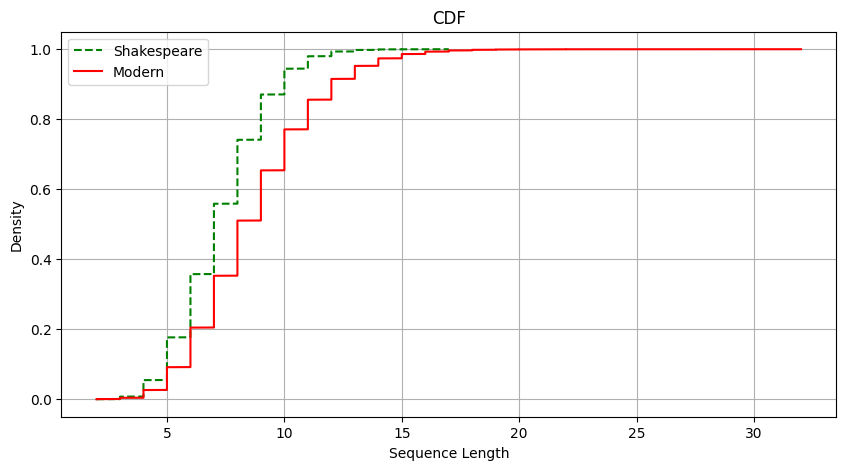

In [7]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
plt.rcParams["figure.figsize"] = (10,5)
# Let's see what length distribution of sentences in both src and trg
src_train_len = []
trg_train_len = []

for (src_snt, trg_snt) in zip(src_train_tok, trg_train_tok):
    src_train_len.append(len(src_snt)) # Store len of an individual src
    trg_train_len.append(len(trg_snt)) # Store len of an individual trg

plt.plot(np.sort(src_train_len), np.arange(len(src_train_len))/len(src_train_len), label="Shakespeare", linestyle="--", color="green")
plt.plot(np.sort(trg_train_len), np.arange(len(trg_train_len))/len(trg_train_len), label="Modern", color="red")
plt.grid()
plt.xlabel("Sequence Length")
plt.ylabel("Density")
plt.legend()
plt.title("CDF")

plt.show()

In [8]:
max_seq_len = 40

def src_processing(tokens, max_seq_len):
  if len(tokens) < max_seq_len:
    tokens += [2]
    left = max_seq_len -len(tokens)
    padding = [0] * left
    tokens += padding
  else:
    tokens = tokens[:max_seq_len-1]
    padding += [2]
  return tokens

def trg_processing(tokens, max_seq_len):
  tokens = [1] + tokens
  if len(tokens) < max_seq_len:
    left = max_seq_len -len(tokens)
    padding = [0] * left
    tokens += padding
  else:
    tokens = tokens[:max_seq_len-1]
  return tokens

def out_decoder(tokens, max_seq_len):
  if len(tokens) < max_seq_len:
    tokens += [2]
    left = max_seq_len -len(tokens)
    padding = [0] * left
    tokens += padding
  else:
    tokens = tokens[:max_seq_len-1]
    padding += [2]
  return tokens


In [9]:

src_id = [src_processing(id, max_seq_len) for id in src_train_tok]

input_trg_id = [trg_processing(id, max_seq_len) for id in trg_train_tok]
output_trg_id = [out_decoder(id, max_seq_len) for id in trg_train_tok]

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
src_id = torch.tensor(src_id)
input_trg_id = torch.tensor(input_trg_id)
output_trg_id = torch.tensor(output_trg_id)

print("Src Shapes: {}; dtype: {}".format(src_id.shape, src_id.dtype))
print("Input Trg Shapes: {}; dtype: {}".format(input_trg_id.shape, input_trg_id.dtype))
print("Output Trg Shapes: {}; dtype: {}".format(output_trg_id.shape, output_trg_id.dtype))

Src Shapes: torch.Size([136519, 40]); dtype: torch.int64
Input Trg Shapes: torch.Size([136519, 40]); dtype: torch.int64
Output Trg Shapes: torch.Size([136519, 40]); dtype: torch.int64


In [11]:
n = int(0.9*len(src_id))
print(n)
src_train_data = src_id[:n]
trg_train_data = input_trg_id[:n]

src_val_data = src_id[n:]
trg_val_data = input_trg_id[n:]

print(src_train_data[0:256].shape)
print(trg_train_data.shape)
print(src_val_data.shape)
print(trg_val_data.shape)




122867
torch.Size([256, 40])
torch.Size([122867, 40])
torch.Size([13652, 40])
torch.Size([13652, 40])


In [78]:

batch_size = 80
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters=200
embd = 16
n_head = 8
n_layer = 6
dropout = 0.2
src_vocab_len = english.vocab_size()
trg_vocab_len = french.vocab_size()


def get_batch(dataset):
    if dataset == 'train':
        indices = np.random.choice(len(src_train_data), batch_size)
        return src_train_data[indices], trg_train_data[indices]
    else:
        indices = np.random.choice(len(src_val_data), batch_size)
        return src_val_data[indices], trg_val_data[indices]

@torch.no_grad()
def estimate_loss():
    losses = {}
    for dataset in ['train', 'val']:
        total_loss = 0
        for _ in range(eval_iters):
            xb, yb = get_batch(dataset)
            print(f"xb shape: {xb.shape}, yb shape: {yb.shape}")
            output = model(xb, yb)
            print(output.shape)
            loss = criterion(output.contiguous().view(-1, trg_vocab_len), yb[:, 1:].contiguous().view(-1))
            print(loss)
            total_loss += loss.item()
        losses[dataset] = total_loss / eval_iters
    return losses


class MaskedHead(nn.Module):
   def __init__(self, head_size):
      super().__init__()
      self.key = nn.Linear(embd, head_size, bias=False)
      self.query = nn.Linear(embd, head_size, bias=False)
      self.value = nn.Linear(embd, head_size, bias=False)
      self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

      self.dropout = nn.Dropout(dropout)

   def forward(self, x):
      B,T,C = x.shape
      k=self.key(x)
      q=self.query(x)
      wei = q@k.transpose(-2,-1) * C**-0.5
      wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
      wei = F.softmax(wei, dim=-1)
      wei = self.dropout(wei)

      v= self.value(x)
      out = wei@v
      return out

class Head(nn.Module):
   def __init__(self, head_size):
      super().__init__()
      self.key = nn.Linear(embd, head_size, bias=False)
      self.query = nn.Linear(embd, head_size, bias=False)
      self.value = nn.Linear(embd, head_size, bias=False)
      self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

      self.dropout = nn.Dropout(dropout)

   def forward(self, x):
      B,T,C = x.shape
      k=self.key(x)
      q=self.query(x)
      wei = q@k.transpose(-2,-1) * C**-0.5
      #wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
      wei = F.softmax(wei, dim=-1)
      wei = self.dropout(wei)

      v= self.value(x)
      out = wei@v
      return out

class DecoderHead(nn.Module):
   def __init__(self, head_size):
      super().__init__()
      self.key = nn.Linear(embd, head_size, bias=False)
      self.query = nn.Linear(embd, head_size, bias=False)
      self.value = nn.Linear(embd, head_size, bias=False)
      self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

      self.dropout = nn.Dropout(dropout)

   def forward(self, x, y):
      B,T,C = x.shape
      #print("decoder head = ", B)
      k=self.key(y)
      q=self.query(x)
      wei = q@k.transpose(-2,-1) * C**-0.5
      #wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
      wei = F.softmax(wei, dim=-1)
      wei = self.dropout(wei)

      v= self.value(y)
      out = wei@v
      return out


class MaskedMultiHeadAttention(nn.Module):
   def __init__(self, num_heads, head_size):
      super().__init__()
      self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)])
      self.proj = nn.Linear(embd, embd)
      self.dropout = nn.Dropout(dropout)

   def forward(self, x):
      out = torch.cat([h(x) for h in self.heads], dim=-1)
      out = self.dropout(self.proj(out))
      return out

class MultiHeadAttention(torch.nn.Module):
  def __init__(self, num_heads, head_size):
      super().__init__()
      self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
      self.proj = nn.Linear(embd, embd)
      self.dropout = nn.Dropout(dropout)

  def forward(self, x):
      out = torch.cat([h(x) for h in self.heads], dim=-1)
      out = self.dropout(self.proj(out))
      return out

class DecoderMultiHeadAttention(torch.nn.Module):
  def __init__(self, num_heads, head_size):
      super().__init__()
      self.heads = nn.ModuleList([DecoderHead(head_size) for _ in range(num_heads)])
      self.proj = nn.Linear(embd, embd)
      self.dropout = nn.Dropout(dropout)

  def forward(self, x, y):

      out = torch.cat([h(x, y) for h in self.heads], dim=-1)
      out = self.dropout(self.proj(out))
      #print("dsa head = ", out.shape)
      return out

class FeedForward(nn.Module):
   def __init__(self, embd):
      super().__init__()
      self.net = nn.Sequential(
         nn.Linear(embd, 4 * embd),
         nn.ReLU(),
         nn.Linear(4 * embd,embd),
         nn.Dropout(dropout),
      )

   def forward(self, x):
      return self.net(x)


class Encoder(torch.nn.Module):
  def __init__(self, embd, n_head):
    super().__init__()
    head_size = embd//n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(embd)
    self.ln1 = nn.LayerNorm(embd)
    self.ln2 = nn.LayerNorm(embd)


  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x


class Decoder(torch.nn.Module):
  def __init__(self, embd, n_head):
    super().__init__()
    head_size = embd//n_head
    self.msa = MaskedMultiHeadAttention(n_head, head_size)
    self.dsa = DecoderMultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(embd)
    self.ln1 = nn.LayerNorm(embd)
    self.ln2 = nn.LayerNorm(embd)
    self.ln3 = nn.LayerNorm(embd)

  def forward(self, x, e_out):
    #print("x = ", x.shape)
    x = x + self.msa(self.ln1(x))
    #print("msa x = ", x.shape)
    #x = x + self.dsa(self.ln2(x), self.ln2(e_out))
    #print("dsa x = ", x.shape)
    x = x + self.ffwd(self.ln3(x))
    return x, e_out

class mySequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            input = module(*input)
        return input


class Transformer(torch.nn.Module):
    def __init__(self, embd, max_seq_len, src_vocab_len, trg_vocab_len, device="cpu"):
        super().__init__()
        # Device and layers
        self.device = device

        # Token Embeddings
        self.src_token_emb = torch.nn.Embedding(src_vocab_len, embd)
        self.trg_token_emb = torch.nn.Embedding(trg_vocab_len, embd)

        # Positional Embeddings
        self.src_pos_enc = torch.nn.Embedding(embedding_dim=embd, num_embeddings=max_seq_len)
        self.trg_pos_enc = torch.nn.Embedding(embedding_dim=embd, num_embeddings=max_seq_len)

        # Encoder
        self.encoders = nn.Sequential(*[Encoder(embd, n_head=n_head) for _ in range(n_layer)])
        # Decoder
        #self.decoders = nn.Sequential(*[Decoder(embd, n_head=n_head) for _ in range(n_layer)])
        self.decoders = mySequential(
                            Decoder(embd, n_head=n_head),
                            Decoder(embd, n_head=n_head),
                            Decoder(embd, n_head=n_head),
                            Decoder(embd, n_head=n_head),
                            Decoder(embd, n_head=n_head),
                            Decoder(embd, n_head=n_head),
                        )
        self.ln_f = nn.LayerNorm(embd)
        self.lm_head = nn.Linear(embd, src_vocab_len)
        self.softmax = nn.LogSoftmax(dim=-1)
        # Generator

    def forward(self, src_in, trg_in):
        # SRC Tokenized
        print(f"trg_in shape: {src_in.shape}")
        src_in = self.src_token_emb(src_in)

        print(f"trg_in shape: {src_in.shape}")

        # pos embedded
        b, t, emb = src_in.shape
        src_in = src_in + self.src_pos_enc(torch.arange(t, device=self.device))[None, :, :].expand(b, t, emb)

        # TRG Tokenized
        trg_in = self.trg_token_emb(trg_in)
        # pos embedded
        b, t, emb = trg_in.shape
        trg_in = trg_in + self.trg_pos_enc(torch.arange(t, device=self.device))[None, :, :].expand(b, t, emb)

        # Encoder
        x = self.encoders(src_in)
        #print("encoder = ", x.shape)
        # Decoder
        y = self.decoders(trg_in, x)
        print("decoder = ", y[0].shape)
        y = self.ln_f(y[0])
        l = self.lm_head(y)
        output = self.softmax(self.output_linear(l))

        return output

In [75]:
model = Transformer(embd, max_seq_len, src_vocab_len, trg_vocab_len)
m = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')
    # evaluate the loss
    output = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss = criterion(output.contiguous().view(-1, trg_vocab_len), yb[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()

xb shape: torch.Size([80, 40]), yb shape: torch.Size([80, 40])
trg_in shape: torch.Size([80, 40])
trg_in shape: torch.Size([80, 40, 16])
decoder =  torch.Size([80, 40, 16])
torch.Size([80, 40, 5000])


RuntimeError: Expected target size [80, 5000], got [80, 39]

In [ ]:

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(french.DecodePieces(m.generate(context, max_new_tokens=500)[0].tolist()))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

batch_size = 64
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters=200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
print(device)

# -----------------------------------------------------

torch.manual_seed(1337)

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding= 'utf-8') as f:
    text = f.read()


chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class Head(nn.Module):
   def __init__(self, head_size):
      super().__init__()
      self.key = nn.Linear(n_embd, head_size, bias=False)
      self.query = nn.Linear(n_embd, head_size, bias=False)
      self.value = nn.Linear(n_embd, head_size, bias=False)
      self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

      self.dropout = nn.Dropout(dropout)

   def forward(self, x):
      B,T,C = x.shape
      k=self.key(x)
      q=self.query(x)
      wei = q@k.transpose(-2,-1) * C**-0.5
      wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
      wei = F.softmax(wei, dim=-1)
      wei = self.dropout(wei)

      v= self.value(x)
      out = wei@v
      return out


class MultiHeadAttention(nn.Module):
   def __init__(self, num_heads, head_size):
      super().__init__()
      self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
      self.proj = nn.Linear(n_embd, n_embd)
      self.dropout = nn.Dropout(dropout)

   def forward(self, x):
      out = torch.cat([h(x) for h in self.heads], dim=-1)
      out = self.dropout(self.proj(out))
      return out

class FeedForward(nn.Module):
   def __init__(self, n_embd):
      super().__init__()
      self.net = nn.Sequential(
         nn.Linear(n_embd, 4 * n_embd),
         nn.ReLU(),
         nn.Linear(4 * n_embd,n_embd),
         nn.Dropout(dropout),
      )

   def forward(self, x):
      return self.net(x)

class Block(nn.Module):
   def __init__(self, n_embd, n_head):
      super().__init__()
      head_size = n_embd //n_head
      self.sa = MultiHeadAttention(n_head, head_size)
      self.ffwd = FeedForward(n_embd)
      self.ln1 = nn.LayerNorm(n_embd)
      self.ln2 = nn.LayerNorm(n_embd)

   def forward(self, x):
      x = x + self.sa(self.ln1(x))
      x = x + self.ffwd(self.ln2(x))
      return x

class BigramLanguageModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)

    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    tok_emb = self.token_embedding_table(idx)
    pos_emb = self.position_embedding_table(torch.arange(T, device = device))
    x = tok_emb + pos_emb
    x = self.blocks(x)
    x = self.ln_f(x)
    logits = self.lm_head(x)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim = -1)
      idx_next = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1)
    return idx

model = BigramLanguageModel()
m = model.to(device)


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


cuda
--2024-05-05 16:28:28--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.007s  

2024-05-05 16:28:28 (160 MB/s) - ‘input.txt’ saved [1115394/1115394]

step 0: train loss 4.2849, val loss 4.2823
step 500: train loss 2.0112, val loss 2.0971
step 1000: train loss 1.6021, val loss 1.7830
step 1500: train loss 1.4412, val loss 1.6396
step 2000: train loss 1.3430, val loss 1.5724
step 2500: train loss 1.2809, val loss 1.5330
step 3000: train loss 1.2268, val loss 1.5094
step 3500: train loss 1.1824, val loss 1.4881
step 4000: train loss 1.1475, val